In [1]:
#import statements
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.enableHiveSupport().appName('AmazonReviewRcommender').getOrCreate()
sc = spark.sparkContext

In [3]:
#check to see if thata is available in HDFS
!hdfs dfs -ls /user/hongyiwderrick/project

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 3 items
-rw-r--r--   3 hongyiwderrick hongyiwderrick           0 2022-04-27 19:14 /user/hongyiwderrick/project/kcore_5.csv
-rw-r--r--   3 hongyiwderrick hongyiwderrick 32072979001 2022-04-27 19:21 /user/hongyiwderrick/project/kcore_5.json
-rw-r--r--   3 hongyiwderrick hongyiwderrick 10544467811 2022-04-27 19:29 /user/hongyiwderrick/project/metadata.json


## 1. Data Preparation

### Load kcore_5 data

In [4]:
# Load metadata.json
df_kcore = spark.read.json("/user/hongyiwderrick/project/kcore_5.json")

In [5]:
df_kcore.show(2)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|0000013714| [0, 0]|    4.0|We use this type ...| 12 3, 2013| ACNGUPJ3A3TM9|         GCM|         Nice Hymnal|    1386028800|
|0000013714| [2, 3]|    5.0|I bought this for...|09 13, 2009|A2SUAM1J3GNN3B| J. McDonald|Heavenly Highway ...|    1252800000|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
only showing top 2 rows



In [7]:
df_kcore.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [8]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col

df_kcore.select([count(when(df_kcore[c].isNull(), c)).alias(c) for c in df_kcore.columns]).show()

+----+-------+-------+----------+----------+----------+------------+-------+--------------+
|asin|helpful|overall|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|
+----+-------+-------+----------+----------+----------+------------+-------+--------------+
|   0|      0|      0|         0|         0|         0|      932551|      0|             4|
+----+-------+-------+----------+----------+----------+------------+-------+--------------+



In [9]:
df_kcore.count()

41135700

In [10]:
df_kcore.select('reviewerID').distinct().count()

3035045

### Load meta data

In [5]:
# Load metadata.json
df_meta = spark.read.json("/user/hongyiwderrick/project/metadata.json")

In [6]:
df_meta.count()

9430088

In [7]:
df_meta.show(2)

+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0001048791| null|           [[Books]]|                null|http://ecx.images...| null|                null|[,,,,, 6334800,,,...|The Crucible: Per...|
|           null|0000143561| null|[[Movies & TV, Mo...|3Pack DVD set - I...|http://g-ecx.imag...|12.99|[, [B0036FO6SI, B...|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------

### Merge kcore with meta

In [6]:
df = df_meta.join(df_kcore, df_kcore.asin == df_meta.asin, "inner").select(
    df_kcore.asin, 
    df_kcore.helpful,
    df_kcore.overall, 
    df_kcore.reviewText, 
    df_kcore.reviewerID,
    df_meta.categories,
    df_meta.price,
    df_meta.related,
    df_meta.title
)

In [7]:
df.show(2)

+----------+-------+-------+--------------------+-------------+----------+-----+--------------------+---------------+
|      asin|helpful|overall|          reviewText|   reviewerID|categories|price|             related|          title|
+----------+-------+-------+--------------------+-------------+----------+-----+--------------------+---------------+
|0002216973| [1, 1]|    5.0|And to me, there'...|AESMLAZX4PI6L| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [1, 1]|    5.0|From the dust jac...|AMVV8VYDTLA78| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
+----------+-------+-------+--------------------+-------------+----------+-----+--------------------+---------------+
only showing top 2 rows



### Write to Hive table

In [7]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [16]:
hive_context.sql("use hongyiwderrick");
hive_context.sql("show tables").show();

+--------------+--------------------+-----------+
|      database|           tableName|isTemporary|
+--------------+--------------------+-----------+
|hongyiwderrick|   business_licenses|      false|
|hongyiwderrick|      chicago_crimes|      false|
|hongyiwderrick|  chicago_crimes_new|      false|
|hongyiwderrick|      facility_types|      false|
|hongyiwderrick|     foodinspections|      false|
|hongyiwderrick|foodinspections_p...|      false|
|hongyiwderrick|             kcore_5|      false|
+--------------+--------------------+-----------+



In [21]:
hive_context.sql("drop table if exists kcore_5")

DataFrame[]

In [22]:
df_kcore.write.mode('overwrite').saveAsTable('kcore_5')

In [24]:
hive_context.sql("select count(*) from kcore_5").show()

+--------+
|count(1)|
+--------+
|41135700|
+--------+



In [18]:
hive_context.sql("use hongyiwderrick");
hive_context.sql("drop table if exists metadata")

DataFrame[]

In [ ]:
#hive_context.sql("select count(*) from metadata").show()

## 2. Natural Language Processing

In [8]:
from pyspark.sql.functions import split, explode, lower
from pyspark.sql.functions import udf
from nltk.sentiment import SentimentIntensityAnalyzer

/software/Anaconda3-5.1.0-hadoop/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [8]:
# including stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# add some non-sense words
stop_words += ['', "-", "many", '"', "go", "one", "much", "get", "also", "would", "make", "i'm", "i've", "us", "going",
               "could", "made", "every", "another", "things", "may", "come", "know", "way", "see", "put", "say", "got",
               "looking", "look", "give", "since", "next", "think", "thought", "bit", "little", "makes", "must", "lot",
               "find", "done", "still", "everything", "might", "wanted", "&", ")", "takes", "anything", "nothing", 
               "said", "that's", "5", "2", "gives", "--", "making", "given", "often", "comes", "getting", "set", 
               "able", "away", "felt", "using", "1", "3", "4", "6", "7", "8", "9", "use", "feel", "used"]

In [9]:
categories_num: list = df.groupBy(df.categories[0][0]).count().sort("count", ascending=False).collect()

In [10]:
top_categories_list = []

for i in range(10):
    top_categories_list.append(categories_num[i][0])
    
top_categories_list

['Books',
 'Electronics',
 'Clothing, Shoes & Jewelry',
 'Movies & TV',
 'Home & Kitchen',
 'Health & Personal Care',
 'Cell Phones & Accessories',
 'Apps for Android',
 'Sports & Outdoors',
 'CDs & Vinyl']

In [11]:
# select top 10 categories 

df_review_cat = df.select("reviewText","categories").where(df.categories[0][0].isin(top_categories_list))

In [11]:
df_review_cat.show(10)

+--------------------+----------+
|          reviewText|categories|
+--------------------+----------+
|And to me, there'...| [[Books]]|
|From the dust jac...| [[Books]]|
|There are only a ...| [[Books]]|
|I bought this boo...| [[Books]]|
|I was looking out...| [[Books]]|
|Lady Julitta de M...| [[Books]]|
|I read this many ...| [[Books]]|
|It seems cruel to...| [[Books]]|
|I am thrilled to ...| [[Books]]|
|Lady Julitta is m...| [[Books]]|
+--------------------+----------+
only showing top 10 rows



In [12]:
def get_compound_scores(text):
    sia = SentimentIntensityAnalyzer()
   
    # Get sentiment scores
    compound_score = sia.polarity_scores(text)['compound']

    return compound_score

get_compound_scores_udf = udf(get_compound_scores)

In [13]:
def get_neg_scores(text):
    sia = SentimentIntensityAnalyzer()
   
    # Get sentiment scores
    neg_score = sia.polarity_scores(text)['neg']

    return neg_score

get_neg_scores_udf = udf(get_neg_scores)

In [14]:
def get_neu_scores(text):
    sia = SentimentIntensityAnalyzer()
   
    # Get sentiment scores
    neu_score = sia.polarity_scores(text)['neu']

    return neu_score

get_neu_scores_udf = udf(get_neu_scores)

In [15]:
def get_pos_scores(text):
    sia = SentimentIntensityAnalyzer()
   
    # Get sentiment scores
    pos_score = sia.polarity_scores(text)['pos']

    return pos_score

get_pos_scores_udf = udf(get_pos_scores)

In [16]:
df_review_cat = df_review_cat.withColumn("compound_score", get_compound_scores_udf(F.col("reviewText")))
df_review_cat = df_review_cat.withColumn("neg_scores", get_neg_scores_udf(F.col("reviewText")))
df_review_cat = df_review_cat.withColumn("neu_scores", get_neu_scores_udf(F.col("reviewText")))
df_review_cat = df_review_cat.withColumn("pos_scores", get_pos_scores_udf(F.col("reviewText")))

In [17]:
df_review_cat.show(2)

+--------------------+----------+--------------+----------+----------+----------+
|          reviewText|categories|compound_score|neg_scores|neu_scores|pos_scores|
+--------------------+----------+--------------+----------+----------+----------+
|And to me, there'...| [[Books]]|        0.9708|     0.078|     0.742|      0.18|
|From the dust jac...| [[Books]]|        0.6416|     0.072|     0.801|     0.126|
+--------------------+----------+--------------+----------+----------+----------+
only showing top 2 rows



In [17]:
from pyspark.sql.types import FloatType

df_review_cat = df_review_cat.withColumn("compound_score", df_review_cat["compound_score"].cast(FloatType()))
df_review_cat = df_review_cat.withColumn("neg_scores", df_review_cat["neg_scores"].cast(FloatType()))
df_review_cat = df_review_cat.withColumn("neu_scores", df_review_cat["neu_scores"].cast(FloatType()))
df_review_cat = df_review_cat.withColumn("pos_scores", df_review_cat["pos_scores"].cast(FloatType()))
df_review_cat = df_review_cat.withColumn("categories", df_review_cat["categories"][0][0])

In [26]:
df_review_cat.printSchema()

root
 |-- reviewText: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- compound_score: float (nullable = true)
 |-- neg_scores: float (nullable = true)
 |-- neu_scores: float (nullable = true)
 |-- pos_scores: float (nullable = true)



In [18]:
df_review_cat_group = df_review_cat.groupBy("categories").avg("compound_score","neg_scores","neu_scores","pos_scores")

In [17]:
#df_review_cat_group = df_review_cat.groupBy("categories").agg(F.avg("compound_score"),F.avg("neg_scores"),F.avg("neu_scores"),F.avg("pos_scores"))

In [19]:
df_review_cat_group1 = df_review_cat.groupBy("categories").agg(F.avg("compound_score"))
df_review_cat_group2 = df_review_cat.groupBy("categories").agg(F.avg("neg_scores"))
df_review_cat_group3 = df_review_cat.groupBy("categories").agg(F.avg("neu_scores"))
df_review_cat_group4 = df_review_cat.groupBy("categories").agg(F.avg("pos_scores"))

In [20]:
df_review_cat_group1.printSchema()

root
 |-- categories: string (nullable = true)
 |-- avg(compound_score): double (nullable = true)



In [42]:
#df_review_cat_group1 = df_review_cat.groupBy("categories").agg(F.percentile_approx("compound_score", 0.5).alias('compound_score_med'))
#df_review_cat_group2 = df_review_cat.groupBy("categories").agg(F.percentile_approx("neg_scores", 0.5).alias('neg_scores_med'))
#df_review_cat_group3 = df_review_cat.groupBy("categories").agg(F.percentile_approx("neu_scores", 0.5).alias('neu_scores_med'))
#df_review_cat_group4 = df_review_cat.groupBy("categories").agg(F.percentile_approx("pos_scores", 0.5).alias('pos_scores_med'))

AttributeError: module 'pyspark.sql.functions' has no attribute 'percentile_approx'

In [51]:
df_review_cat_group1.count()

10

In [ ]:
#df_review_cat_group1.show()

In [ ]:
#df_sia_cat1 = df_review_cat_group1.join(df_review_cat_group2, df_review_cat_group1.categories == df_review_cat_group2.categories, "inner")
#df_sia_cat2 = df_sia_cat1.join(df_review_cat_group3, df_review_cat_group3.categories == df_sia_cat1.categories, "inner")
#df_sia_cat = df_sia_cat2.join(df_review_cat_group4, df_review_cat_group4.categories == df_sia_cat2.categories, "inner")

In [ ]:
#df_sia_cat_top15 = df_sia_cat.filter(df_sia_cat.categories.isin(top_categories_list[0:5]))
#df_sia_cat_top610 = df_sia_cat.filter(df_sia_cat.categories.isin(top_categories_list[5:10]))

In [ ]:
#df_review_cat_group_top15.count()

In [21]:
pdf1 = df_review_cat_group1.toPandas()

In [22]:
pdf2 = df_review_cat_group2.toPandas()

In [23]:
pdf3 = df_review_cat_group3.toPandas()

In [24]:
pdf4 = df_review_cat_group4.toPandas()

In [ ]:
#pdf = df_review_cat_group.toPandas()

In [55]:
import pandas as pd

pdf13 = pd.merge(pdf1, pdf3, how='inner', on = 'categories')
pdf134 = pd.merge(pdf13, pdf4, how='inner', on = 'categories')
pdf1234 = pd.merge(pdf134, pdf2, how='inner', on = 'categories')

In [56]:
pdf1234.head()

,categories,avg(compound_score),avg(neu_scores),avg(pos_scores),avg(neg_scores)
0,Home & Kitchen,0.603949,0.769890,0.188928,0.040859
1,Sports & Outdoors,0.575877,0.772629,0.183810,0.043182
2,Electronics,0.541504,0.787220,0.166235,0.046066
3,CDs & Vinyl,0.739294,0.755187,0.203045,0.041735
4,Books,0.624272,0.752890,0.195716,0.051313


In [60]:
pdf1234.columns = ['Categories', 'Compound_score', 'Neu_scores','Pos_scores', 'Neg_scores']

In [57]:
import os

os.getcwd()

'/home/hongyiwderrick/Project'

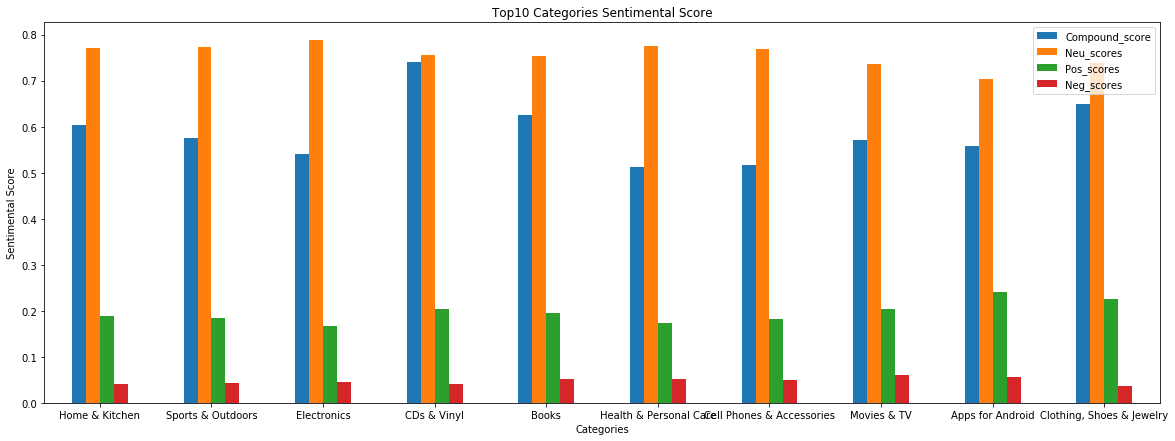

In [62]:
pdf1234.plot(figsize=(20,7), kind='bar', x="Categories", rot="0")
plt.xlabel("Categories")
plt.ylabel("Sentimental Score")
plt.title("Top10 Categories Sentimental Score")
plt.savefig(f"./Sentimental Score.jpg")
plt.show()